# Import libraries and functions

In [85]:
from HoangUyen_Le_Module import dropping_column, replacing_convert

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
import math

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict

# Unemployment statistics in UK from 2004 to 2019

# Section 1: Data importing and cleansing

In [88]:
data = pd.read_csv('C:/Users/hoang/OneDrive/Desktop/unemployment-by-region.csv', sep = ',', header = "infer", index_col= None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35100 entries, 0 to 35099
Data columns (total 15 columns):
Measure                35100 non-null object
Measure_type           35100 non-null object
Ethnicity              35100 non-null object
Ethnicity_type         35100 non-null object
Time                   35100 non-null int64
Time_Type              35100 non-null object
Region                 35100 non-null object
Age                    35100 non-null object
Age_Type               35100 non-null object
Sex                    35100 non-null object
Value                  35100 non-null object
confidence_interval    35100 non-null object
Numerator              35100 non-null object
denominator            35100 non-null object
samp_size              35100 non-null object
dtypes: int64(1), object(14)
memory usage: 4.0+ MB


In [89]:
nu = data.nunique().reset_index()
nu.columns = ['feature','number of unique']
nu

,feature,number of unique
0,Measure,1
1,Measure_type,1
2,Ethnicity,13
3,Ethnicity_type,4
4,Time,15
5,Time_Type,1
6,Region,12
7,Age,5
8,Age_Type,1
9,Sex,3


Dropping useless columns

In [90]:
dropping_column(data) # dropping useless columns

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35100 entries, 0 to 35099
Data columns (total 11 columns):
Ethnicity              35100 non-null object
Ethnicity_type         35100 non-null object
Time                   35100 non-null int64
Region                 35100 non-null object
Age                    35100 non-null object
Sex                    35100 non-null object
Value                  35100 non-null object
confidence_interval    35100 non-null object
Numerator              35100 non-null object
denominator            35100 non-null object
samp_size              35100 non-null object
dtypes: int64(1), object(10)
memory usage: 2.9+ MB


Converting data-type into proper types

In [93]:
def replacing_convert(dataset, column_list):
    for i in column_list:            
        dataset[i] = dataset[i].apply(lambda x: np.nan if x == '?' else x)
        dataset[i] = dataset[i].apply(lambda x: np.nan if x == '-' else x)
        data[i] = data[i].astype(str).astype(float)

In [94]:
column_list = list(data[['Value', 'samp_size', 'Numerator', 'denominator']])
replacing_convert(data, column_list) # change '?' / '-' values with NaN and convert data type into float64

In [95]:
key = data['Value'].isnull()
blanks = data.loc[key]
full = data.loc[~key]

Filling missing values

In [96]:
aaa = pd.DataFrame(full.groupby(['Time', 'Region', 'Age', 'Sex'])['samp_size'].mean()).reset_index()
bbb = pd.DataFrame(full.groupby(['Time', 'Region', 'Age', 'Sex'])['denominator'].mean()).reset_index()
ccc = pd.DataFrame(full.groupby(['Time', 'Region', 'Age', 'Sex'])['Numerator'].mean()).reset_index()
blanks = blanks.merge(aaa,on=('Time', 'Region', 'Age', 'Sex'),how="left")
blanks = blanks.merge(bbb,on=('Time', 'Region', 'Age', 'Sex'),how="left")
blanks = blanks.merge(ccc,on=('Time', 'Region', 'Age', 'Sex'),how="left")

blanks.rename(columns={'samp_size_y':'samp_size', 'denominator_y':'denominator','Numerator_y':'Numerator'},inplace=True)
blanks.drop(['samp_size_x','denominator_x', 'Numerator_x'],inplace=True,axis=1)
blanks = blanks.loc[~(blanks['samp_size'].isnull())]
blanks['Value'] = blanks['Numerator']/blanks['denominator']*100

In [97]:
blanks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17846 entries, 2 to 17975
Data columns (total 11 columns):
Ethnicity              17846 non-null object
Ethnicity_type         17846 non-null object
Time                   17846 non-null int64
Region                 17846 non-null object
Age                    17846 non-null object
Sex                    17846 non-null object
Value                  17846 non-null float64
confidence_interval    17846 non-null object
samp_size              17846 non-null float64
denominator            17846 non-null float64
Numerator              17846 non-null float64
dtypes: float64(4), int64(1), object(6)
memory usage: 1.6+ MB


In [98]:
data = pd.concat([full,blanks])

C:\Users\hoang\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34970 entries, 0 to 17975
Data columns (total 11 columns):
Age                    34970 non-null object
Ethnicity              34970 non-null object
Ethnicity_type         34970 non-null object
Numerator              34970 non-null float64
Region                 34970 non-null object
Sex                    34970 non-null object
Time                   34970 non-null int64
Value                  34970 non-null float64
confidence_interval    34970 non-null object
denominator            34970 non-null float64
samp_size              34970 non-null float64
dtypes: float64(4), int64(1), object(6)
memory usage: 3.2+ MB


# Section 2: Data visualization

In [100]:
graph1 = pd.DataFrame(data.groupby(['Time', 'Region'])['Numerator','denominator' ].sum()).reset_index()
graph1['Value'] = graph1['Numerator']/graph1['denominator']*100

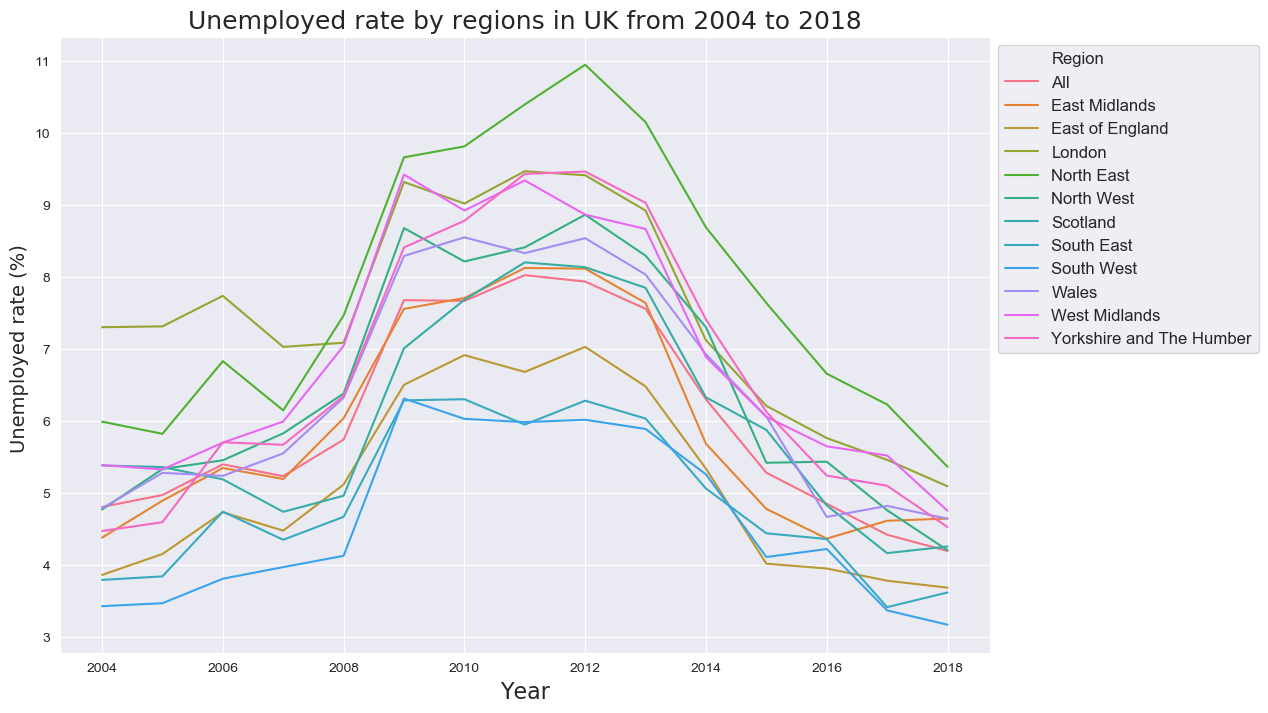

In [101]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(x='Time', y = 'Value', data = graph1, hue = 'Region')
plt.legend(bbox_to_anchor=(1,1), loc = "upper left", prop={"size":12})
plt.rcParams.update({'font.size':14})
plt.title('Unemployed rate by regions in UK from 2004 to 2018', fontname='DejaVu Sans', fontsize=18)
plt.xlabel('Year', fontname='DejaVu Sans', fontsize=16)
plt.ylabel('Unemployed rate (%) ', fontname='DejaVu Sans', fontsize=14)
plt.show()

13 different regions in the United Kingdom share similar pattern throughout 15-year period. In 2008, global economic crisis broke out, led to a bunch of negative influences to the economy all over the world, including unemployment rate. This rate was almost doubled immediately after a year and keep hovering around that rate for the next 4 years. Until to 2013, this dark situation in labor field was gradually improved, and the lowest rate of unemployed was recorded at the bottom peak in 2018. London and North East are witnessed to be regions obtain highest percentage of unemployed over the whole period, while South East and South West got the lowest rate in comparison. 

In [102]:
graph2 = pd.DataFrame(data.groupby(['Time', 'Age'])['Numerator','denominator' ].sum()).reset_index()
graph2['Value'] = graph2['Numerator']/graph2['denominator']*100

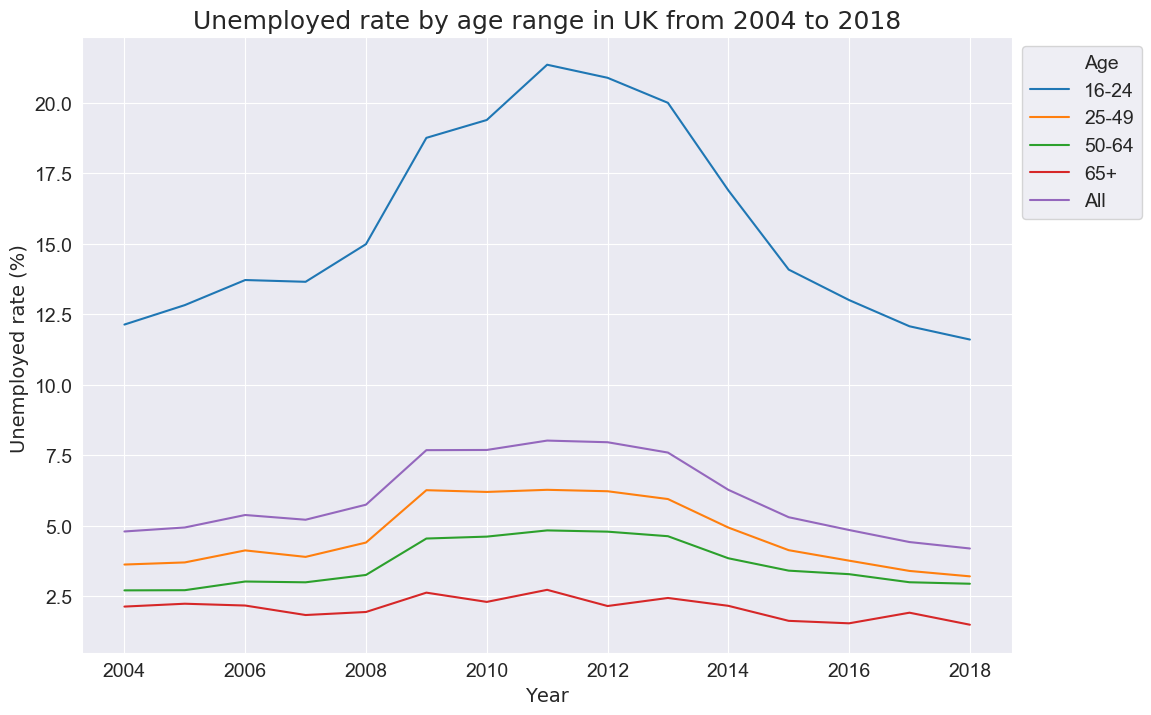

In [103]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
sns.lineplot(x='Time', y = 'Value', data = graph2, hue = 'Age')
plt.legend(bbox_to_anchor=(1,1), loc = "upper left", prop={"size":14})
plt.rcParams.update({'font.size':14})
plt.title('Unemployed rate by age range in UK from 2004 to 2018', fontname='DejaVu Sans', fontsize=18)
plt.xlabel('Year', fontname='DejaVu Sans')
plt.ylabel('Unemployed rate (%) ', fontname='DejaVu Sans')
plt.show()

In term of working age, youngest range (16-24) is considered as the most unsuccessful on to get a job. This consequence is caused by some specific reasons, such as they pursue higher education or stick on a part-time job and then travelling instead of getting an official career like other age group. In economy global crisis, this blue line noticeably rocketed, almost 21% at the peak in 2011.

In [104]:
graph3 = pd.DataFrame(data.groupby(['Ethnicity'])['Value'].mean()).reset_index()
graph3 = graph3.sort_values('Value', ascending=False)

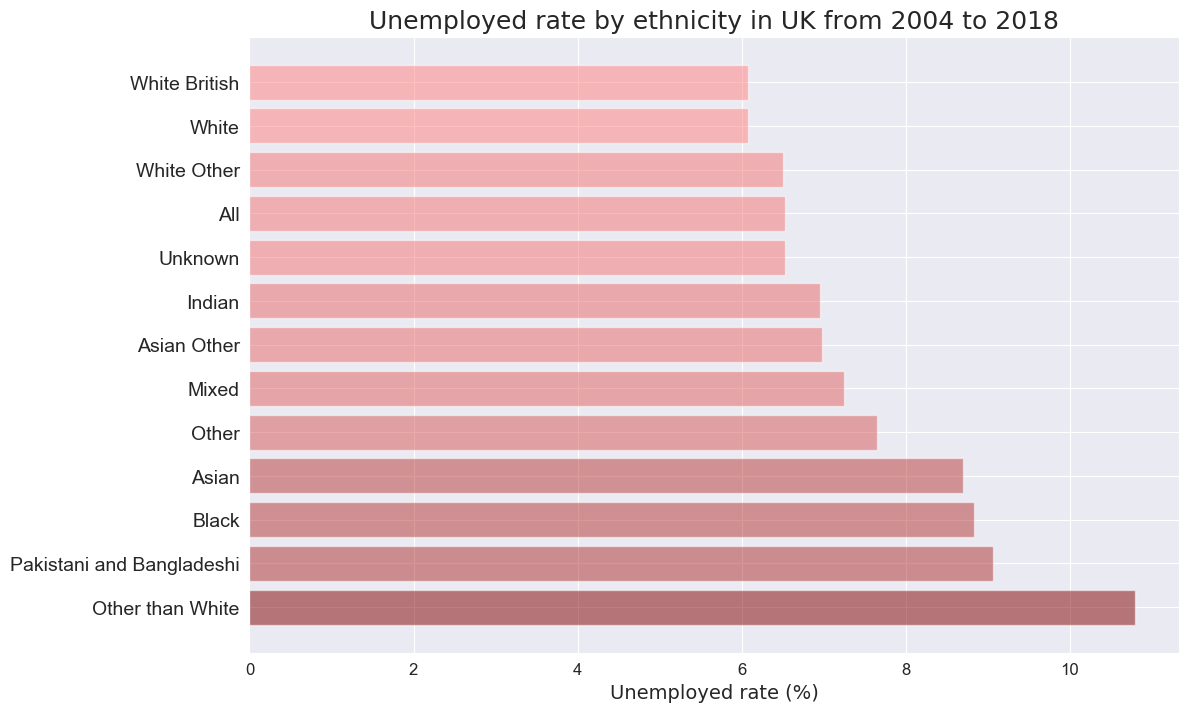

In [105]:
likeability_scores = np.array(graph3['Value'])

data_normalizer = mp.colors.Normalize()

color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, .5, .5),
                  (1.0, 0, 0)],
        "blue": [(0, .5, .5),
                 (1.0, 0, 0)]
    }
)

sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.barh(graph3['Ethnicity'], graph3['Value'], align='center', alpha=0.5, color=color_map(data_normalizer(likeability_scores)))
plt.yticks(graph3['Ethnicity'],fontsize=14)
plt.xticks(fontsize=12)
plt.title('Unemployed rate by ethnicity in UK from 2004 to 2018', fontname='DejaVu Sans', fontsize=18)
plt.xlabel('Unemployed rate (%)', fontname='DejaVu Sans', fontsize=14)
plt.show()

In term of ethnicity, White people get the lower unemployment rate than other group. By contract, Other than White, Pakistani and Bangladeshi is witnessed as highest rate group. However, the gap between bottom and top group in this graph is not significant, so ethnicity is assumed to less affect the percentage of unemployed.	

# Section 3: Descriptive/ Predictive analytics

# 1. Log transforming

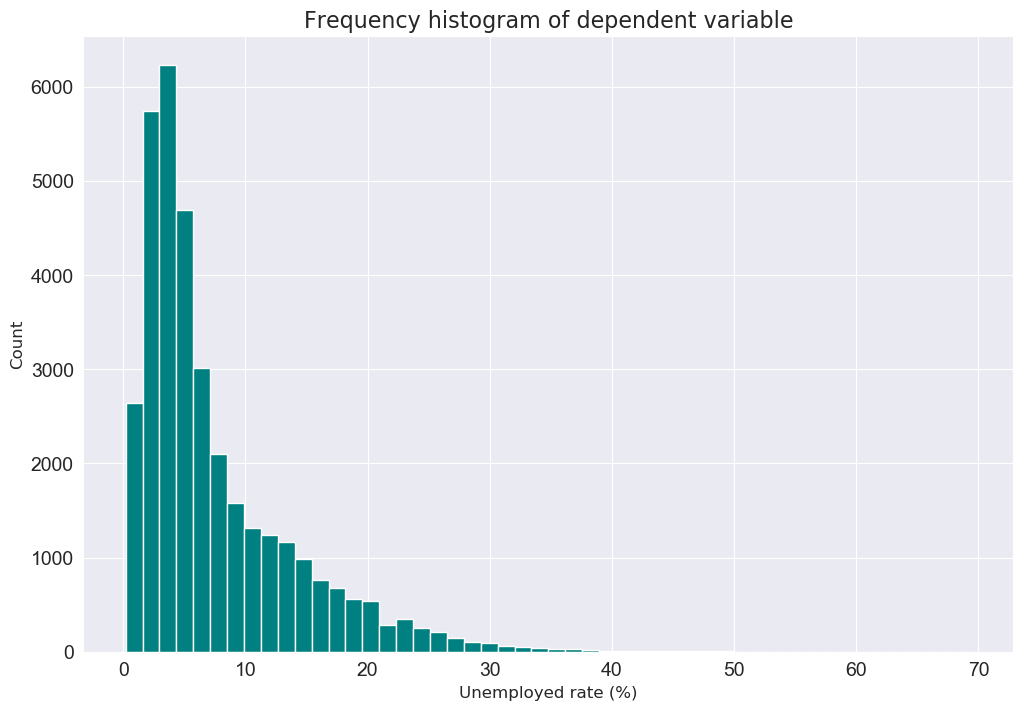

In [106]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.hist(data['Value'],50,color='teal')
plt.title('Frequency histogram of dependent variable', fontname='DejaVu Sans', fontsize=16)
plt.xlabel('Unemployed rate (%)', fontname='DejaVu Sans', fontsize=12)
plt.ylabel('Count', fontname='DejaVu Sans', fontsize=12)
plt.show()

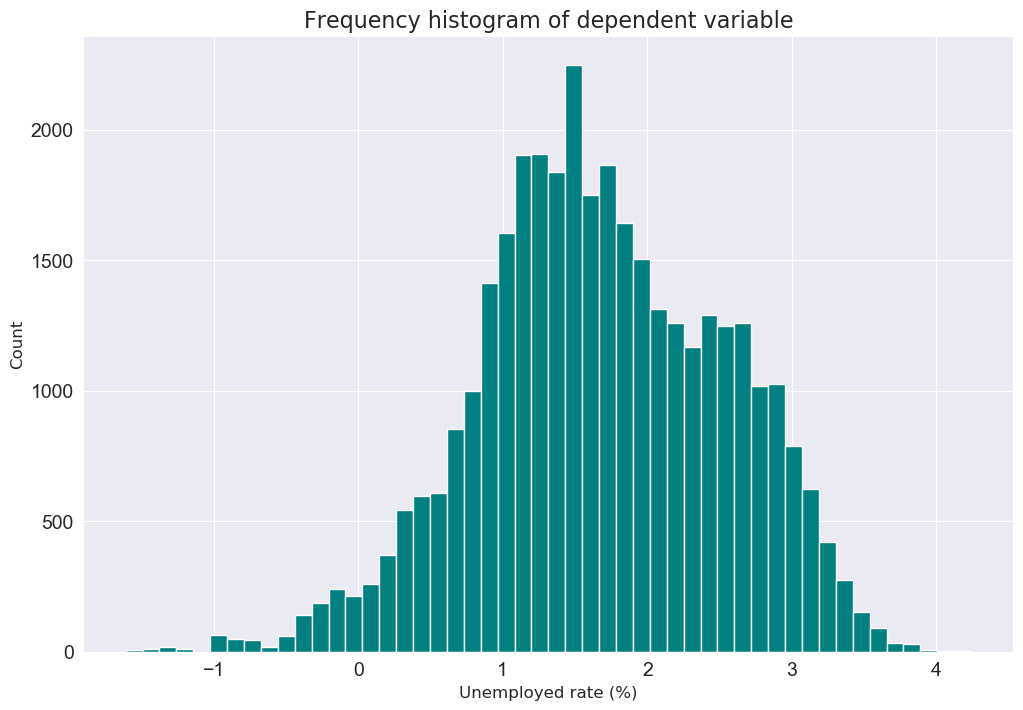

In [107]:
data['Value'] = np.log(data['Value'])
plt.figure(figsize=(12,8))
plt.hist(data['Value'],50,color='teal')
plt.title('Frequency histogram of dependent variable', fontname='DejaVu Sans', fontsize=16)
plt.xlabel('Unemployed rate (%)', fontname='DejaVu Sans', fontsize=12)
plt.ylabel('Count', fontname='DejaVu Sans', fontsize=12)
plt.show()

# 2. Dummies variables

In [32]:
data2 = data[['Age', 'Ethnicity', 'Region', 'Sex', 'Time', 'Value']]

In [33]:
data2

,Age,Ethnicity,Region,Sex,Time,Value
0,16-24,All,All,All,2004,2.509599
1,16-24,All,All,Women,2004,2.388763
2,16-24,All,All,Men,2004,2.610070
3,25-49,All,All,All,2004,1.308333
4,25-49,All,All,Women,2004,1.252763
...,...,...,...,...,...,...
17971,50-64,White Other,Yorkshire and The Humber,Women,2018,1.113180
17972,50-64,White Other,Yorkshire and The Humber,Men,2018,1.170751
17973,65+,White Other,Yorkshire and The Humber,All,2018,-0.486533
17974,65+,White Other,Yorkshire and The Humber,Women,2018,-0.077989


In [34]:
dummies_age = pd.get_dummies(data2.Age)
dummies_age.drop(['All'],inplace=True, axis = 1)

dummies_ethnicity = pd.get_dummies(data2.Ethnicity)
dummies_ethnicity.drop(['All'],inplace=True, axis = 1)

dummies_region = pd.get_dummies(data2.Region)
dummies_region.drop(['All'],inplace=True, axis = 1)

dummies_sex = pd.get_dummies(data2.Sex)
dummies_sex.drop(['All'],inplace=True, axis = 1)

In [35]:
dummies_data = pd.concat([data2['Value'],data2['Time'], dummies_age,dummies_ethnicity,dummies_region,dummies_sex], axis = 'columns')
dummies_data

,Value,Time,16-24,25-49,50-64,65+,Asian,Asian Other,Black,Indian,...,North East,North West,Scotland,South East,South West,Wales,West Midlands,Yorkshire and The Humber,Men,Women
0,2.509599,2004,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.388763,2004,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.610070,2004,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1.308333,2004,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.252763,2004,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17971,1.113180,2018,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
17972,1.170751,2018,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
17973,-0.486533,2018,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
17974,-0.077989,2018,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [36]:
y = dummies_data.Value
df = dummies_data.loc[:, dummies_data.columns != 'Value']
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)

# 3. Buiding models

In [37]:
model1 = RandomForestRegressor(n_estimators = 500, random_state = 0)
model1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

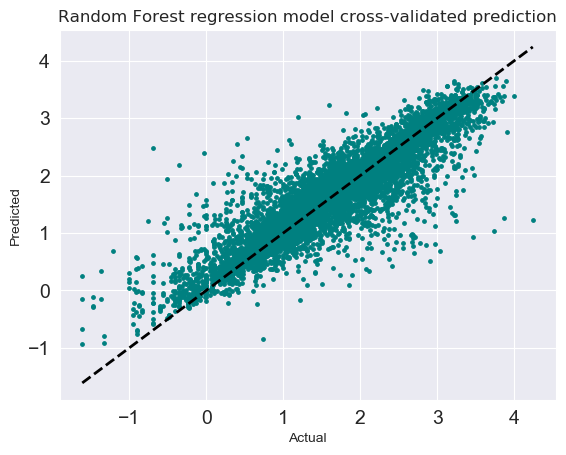

The accuracy of Random Forest Regression model 
 R-Square: 0.8429349980206231 
 MAE: 0.19944116312402693 
 MSE: 0.11458604324922513 
 RMSE: 0.3385056029805491


In [38]:
y_pred1 = cross_val_predict(model1, X_test, y_test, cv=10)
sns.set_style('darkgrid')
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred1, s = 6, color = 'teal')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax.set_xlabel('Actual', fontsize=10)
ax.set_ylabel('Predicted', fontsize=10)
ax.set_title('Random Forest regression model cross-validated prediction', fontname='DejaVu Sans', fontsize=12)
plt.show()

r21 = r2_score(y_test, y_pred1)
mae1 = mean_absolute_error(y_test, y_pred1)
mse1 = mean_squared_error(y_test, y_pred1)
rms1 = math.sqrt(mean_squared_error(y_test, y_pred1))
print('The accuracy of Random Forest Regression model \n R-Square: {} \n MAE: {} \n MSE: {} \n RMSE: {}'.format(r21, mae1, mse1, rms1))

In [39]:
params = {'n_estimators': 500, 'max_depth': 2, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
model2 = GradientBoostingRegressor(**params)
model2.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

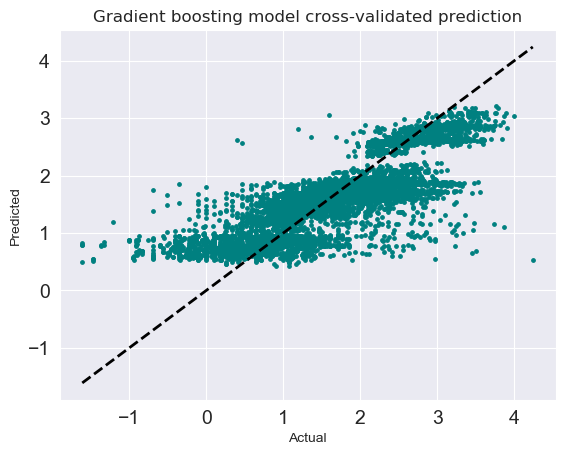

In [40]:
y_pred2 = cross_val_predict(model2, X_test, y_test, cv=10)
sns.set_style('darkgrid')
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred2, s = 6, color = 'teal')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax.set_xlabel('Actual', fontsize=10)
ax.set_ylabel('Predicted', fontsize=10)
ax.set_title('Gradient boosting model cross-validated prediction', fontname='DejaVu Sans', fontsize=12)
plt.show()

In [45]:
r22 = r2_score(y_test, y_pred2)
mae2 = mean_absolute_error(y_test, y_pred2)
mse2 = mean_squared_error(y_test, y_pred2)
rms2 = math.sqrt(mean_squared_error(y_test, y_pred2))
print('The accuracy of Gradient boosting Regression model \n R-Square: {} \n MAE: {} \n MSE: {} \n RMSE: {}'.format(r22, mae2, mse2, rms2))

The accuracy of Gradient boosting Regression model 
 R-Square: 0.7042972073356399 
 MAE: 0.33518970288738126 
 MSE: 0.2157286000200349 
 RMSE: 0.4644659298807986


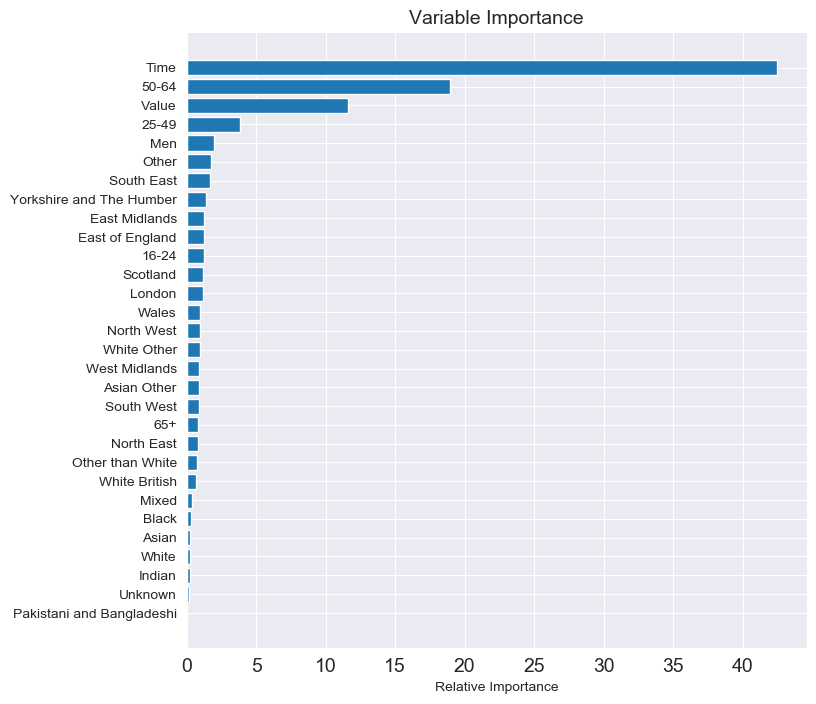

In [48]:
feature_importance = model1.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.sum())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, dummies_data.columns[sorted_idx], fontsize = 10)
plt.xlabel('Relative Importance', fontsize = 10)
plt.title('Variable Importance', fontsize = 14)
plt.show()

# Test of my custom function